This notebook implements supervised weights for approximating the solution to the one-dimensional Gross-Pitavskii equation.

# Import Libraries

In [ ]:
%%capture
!pip install pytorch-optimizer
!git clone https://github.com/facebookresearch/optimizers.git
%cd optimizers
!pip install .
%cd ..

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import numpy as np
import os
from torch.autograd import grad
from scipy.special import hermite
# from adabelief_pytorch import AdaBelief
from pytorch_optimizer import QHAdam, AdaHessian, Ranger21, SophiaH, Shampoo
from distributed_shampoo import AdamGraftingConfig, DistributedShampoo, DefaultEigenvalueCorrectedShampooConfig
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.utils
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


# Physics Informed Neural Network

In [ ]:
class ResidualBlock(nn.Module):
    """
    Residual block with skip connections to improve gradient flow.
    """

    def __init__(self, dim):
        super().__init__()
        self.lin1 = nn.Linear(dim, dim)
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, x):
        return x + self.lin2(torch.tanh(self.lin1(x)))


class SinusoidalLayer(nn.Module):
    """
    Layer with sinusoidal activations to better capture oscillatory behavior.
    """

    def __init__(self, in_features, out_features):
        super().__init__()
        self.omega = nn.Parameter(torch.randn(in_features, out_features))
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return torch.sin(self.omega * x) + self.linear(x)


class ImprovedGrossPitaevskiiPINN(nn.Module):
    """
    Improved Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, mode=0, gamma=1.0):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        mode : int, optional
            Mode number (default is 0).
        gamma : float, optional
            Interaction strength parameter.
        """
        super().__init__()
        self.layers = layers
        self.mode = mode  # Mode number (n)
        self.gamma = gamma  # Interaction strength parameter
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed

        # Build the network with architecture adapted to mode number
        self.network = self.build_network()

        # Maximum order for Hermite polynomial basis
        self.max_hermite_order = max(10, mode + 3)

        # Track training progress
        self.epoch = 0

    def build_network(self):
        """
        Build the neural network with architecture adapted to the mode number.
        For higher modes, we use more complex architectures.
        """
        layers = []

        # Input embedding layer
        layers.append(nn.Linear(1, self.layers[1]))

        # If mode >= 3, add sinusoidal layer to better capture oscillations
        if self.mode >= 3:
            layers.append(SinusoidalLayer(self.layers[1], self.layers[1]))
        else:
            layers.append(nn.Tanh())

        # Hidden layers with residual blocks for better gradient flow
        for i in range(1, len(self.layers) - 2):
            if i < len(self.layers) - 2:
                # Add residual blocks between hidden layers
                layers.append(ResidualBlock(self.layers[i]))
                layers.append(nn.Tanh())

        # Output layer
        layers.append(nn.Linear(self.layers[-2], self.layers[-1]))

        return nn.Sequential(*layers)

    def hermite_features(self, x, max_order=None):
        """
        Compute Hermite polynomial features up to max_order for input enrichment.
        """
        if max_order is None:
            max_order = self.max_hermite_order

        features = []
        for n in range(max_order):
            features.append(self.weighted_hermite(x, n).unsqueeze(1))
        return torch.cat(features, dim=1)

    def weighted_hermite(self, x, n):
        """
        Compute the weighted Hermite polynomial solution for the linear case (gamma = 0).
        """
        # Calculate Hermite polynomial values
        H_n = hermite(n)(x.cpu().detach().numpy())

        # Normalization factor
        norm_factor = (2 ** n * math.factorial(n) * np.sqrt(np.pi)) ** (-0.5)

        # Convert to tensor and apply exponential damping
        weighted_hermite = norm_factor * torch.exp(-x ** 2 / 2) * torch.tensor(H_n, dtype=torch.float32).to(device)

        return weighted_hermite

    def forward(self, inputs):
        """
        Forward pass through the neural network.
        """
        return self.network(inputs)

    def parity_enforced_forward(self, x):
        """
        Enforce correct parity (symmetry/antisymmetry) in the forward pass.
        """
        u_pred = self.forward(x)
        u_reflected = self.forward(-x)

        # For even modes (0,2,4...)
        if self.mode % 2 == 0:
            return (u_pred + u_reflected) / 2  # Force symmetry
        else:
            return (u_pred - u_reflected) / 2  # Force antisymmetry

    def get_complete_solution(self, x, perturbation=None, mode=None, enforce_parity=True):
        """
        Get the complete solution by combining the base Hermite solution with the neural network perturbation.
        """
        if mode is None:
            mode = self.mode

        if perturbation is None:
            if enforce_parity:
                perturbation = self.parity_enforced_forward(x)
            else:
                perturbation = self.forward(x)

        base_solution = self.weighted_hermite(x, mode)
        return base_solution + perturbation

    def compute_potential(self, x, potential_type="harmonic", **kwargs):
        """
        Compute potential function for the 1D domain.
        """
        if potential_type == "harmonic":
            omega = kwargs.get('omega', 1.0)  # Frequency for harmonic potential
            V = 0.5 * omega ** 2 * x ** 2
        elif potential_type == "gaussian":
            a = kwargs.get('a', 0.0)  # Center of the Gaussian
            V = torch.exp(-(x - a) ** 2)
        elif potential_type == "periodic":
            V0 = kwargs.get('V0', 1.0)  # Depth of the potential
            k = kwargs.get('k', 2 * np.pi / 5.0)  # Wave number for periodic potential
            V = V0 * torch.cos(k * x) ** 2
        else:
            raise ValueError(f"Unknown potential type: {potential_type}")
        return V

    def compute_derivatives(self, x, u):
        """
        Compute first and second derivatives of u with respect to x.

        Parameters:
        -----------
        x : torch.Tensor
            Input points, must have requires_grad=True
        u : torch.Tensor
            Function values at input points

        Returns:
        --------
        tuple: (u_x, u_xx)
            First and second derivatives
        """
        # Compute first derivative
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
        )[0]

        # Compute second derivative
        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=x,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
        )[0]

        return u_x, u_xx

    def pde_loss(self, x, gamma, potential_type="harmonic", precomputed_potential=None):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation.
        μψ = -1/2 ∇²ψ + Vψ + γ|ψ|²ψ

        Parameters:
        -----------
        x : torch.Tensor
            Input points, must have requires_grad=True
        gamma : float
            Interaction strength
        potential_type : str
            Type of potential
        precomputed_potential : torch.Tensor, optional
            Precomputed potential values

        Returns:
        --------
        tuple: (pde_loss, pde_residual, lambda_pde, u)
            PDE loss, residual, chemical potential, wavefunction
        """
        # Use parity-enforced forward pass
        perturbation = self.parity_enforced_forward(x)

        # Get the complete solution
        u = self.get_complete_solution(x, perturbation, enforce_parity=False)

        # Compute derivatives
        u_x, u_xx = self.compute_derivatives(x, u)

        # Compute potential
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(x, potential_type)

        # Calculate terms in GPE
        kinetic = -0.5 * u_xx
        potential = V * u
        interaction = gamma * u ** 3

        # Calculate chemical potential using variational approach
        numerator = torch.mean(u * (kinetic + potential + interaction))
        denominator = torch.mean(u ** 2)
        lambda_pde = numerator / denominator

        # Residual of the GPE
        pde_residual = kinetic + potential + interaction - lambda_pde * u

        # PDE loss (mean squared residual)
        pde_loss = torch.mean(pde_residual ** 2)

        return pde_loss, pde_residual, lambda_pde, u

    def riesz_loss(self, x, gamma, potential_type="harmonic", precomputed_potential=None):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.
        E[ψ] = ∫[|∇ψ|²/2 + V|ψ|² + γ|ψ|⁴/2]dx
        This corresponds to Algorithm 2 in the paper at https://arxiv.org/pdf/1208.2123

        Parameters:
        -----------
        x : torch.Tensor
            Input points, must have requires_grad=True
        gamma : float
            Interaction strength
        potential_type : str
            Type of potential
        precomputed_potential : torch.Tensor, optional
            Precomputed potential values

        Returns:
        --------
        tuple: (riesz_energy, lambda_riesz, u)
            Riesz energy, chemical potential, wavefunction
        """
        # Use parity-enforced forward pass
        perturbation = self.parity_enforced_forward(x)

        # Get the complete solution
        u = self.get_complete_solution(x, perturbation, enforce_parity=False)

        # Compute first derivative
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=x,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
        )[0]

        # Calculate dx for proper integration
        dx = x[1] - x[0]

        # Calculate normalization factor
        norm_factor = torch.sum(u ** 2) * dx

        # Kinetic energy term
        kinetic_term = 0.5 * torch.sum(u_x ** 2) * dx / norm_factor

        # Potential term
        if precomputed_potential is not None:
            V = precomputed_potential
        else:
            V = self.compute_potential(x, potential_type)
        potential_term = torch.sum(V * u ** 2) * dx / norm_factor

        # Interaction term
        interaction_term = 0.5 * gamma * torch.sum(u ** 4) * dx / norm_factor

        # Total energy
        riesz_energy = kinetic_term + potential_term + interaction_term

        # For the harmonic oscillator ground state, chemical potential equals energy
        lambda_riesz = riesz_energy

        return riesz_energy, lambda_riesz, u

    def boundary_loss(self, boundary_points, boundary_values):
        """
        Compute the boundary loss for the boundary conditions.
        """
        # Ensure boundary points require grad
        if not boundary_points.requires_grad:
            boundary_points = boundary_points.clone().detach().requires_grad_(True)

        u_pred = self.forward(boundary_points)
        full_u = self.get_complete_solution(boundary_points, u_pred)
        return torch.mean((full_u - boundary_values) ** 2)

    def symmetry_loss(self, x):
        """
        Compute the symmetry loss to enforce u(x) = u(-x) for even modes
        and u(x) = -u(-x) for odd modes.
        """
        # Evaluate u(x) and u(-x)
        u_original = self.forward(x)
        u_reflected = self.forward(-x)

        # For odd modes, apply anti-symmetry condition
        if self.mode % 2 == 1:
            return torch.mean((u_original + u_reflected) ** 2)
        else:
            return torch.mean((u_original - u_reflected) ** 2)

    def normalization_loss(self, u, dx):
        """
        Compute normalization loss using proper numerical integration.
        """
        integral = torch.sum(u ** 2) * dx
        return (integral - 1.0) ** 2

    def node_constraint_loss(self, x, u):
        """
        Enforce that the solution has the correct number of nodes (zeros)
        based on the mode number.
        """
        # For mode n, there should be n nodes (zeros)
        # We estimate this by counting sign changes
        signs = torch.sign(u)
        # Count sign changes (excluding zeros)
        non_zeros = signs != 0
        if torch.sum(non_zeros) < 2:  # Not enough non-zero points to check
            return torch.tensor(0.0, device=device)

        signs_filtered = signs[non_zeros]
        crossings = torch.sum(torch.abs(signs_filtered[1:] - signs_filtered[:-1]) > 1.0) / 2

        # Penalty grows with difference from expected number of nodes
        return 5.0 * torch.abs(crossings - self.mode) ** 2

    def frequency_loss(self, u, dx):
        """
        Add constraints in the frequency domain to better capture oscillations.
        Particularly useful for higher modes.
        """
        if self.mode < 3:
            return torch.tensor(0.0, device=device)

        # Compute FFT
        ft = torch.fft.rfft(u.squeeze())

        # For mode n, we expect significant components up to frequency n
        # Create expected spectrum (Gaussian centered at mode number)
        freqs = torch.fft.rfftfreq(u.shape[0], dx.item())
        n_freqs = freqs.shape[0]

        # Simple approximation of expected spectrum shape
        expected_peak = min(self.mode, n_freqs - 1)
        expected_spectrum = torch.exp(
            -(torch.arange(n_freqs, device=device) - expected_peak) ** 2 / (self.mode / 2 + 1) ** 2)

        # Normalize both spectra
        ft_norm = torch.abs(ft) / (torch.sum(torch.abs(ft)) + 1e-10)
        expected_spectrum = expected_spectrum / (torch.sum(expected_spectrum) + 1e-10)

        # Compute loss as difference between actual and expected spectra shapes
        # Focus on the first several components which are most important
        max_freq = min(2 * self.mode + 3, n_freqs)
        return torch.mean((ft_norm[:max_freq] - expected_spectrum[:max_freq]) ** 2)

# Initialize Weights

In [ ]:
def advanced_initialization(m, mode):
    """
    Initialize network weights with consideration of the mode number.
    Higher modes get special initialization to better capture oscillations.
    """
    if isinstance(m, nn.Linear):
        # Scale gain inversely with mode
        gain = 1.0 / (1.0 + 0.1 * mode)

        # Xavier uniform initialization
        nn.init.xavier_uniform_(m.weight, gain=gain)

        # Initialize biases
        m.bias.data.fill_(0.01)

    elif isinstance(m, SinusoidalLayer):
        # Initialize frequency parameters
        # Higher frequencies for higher modes
        scale = 1.0 + 0.2 * mode
        m.omega.data.uniform_(-scale, scale)

        # Initialize linear part
        nn.init.xavier_uniform_(m.linear.weight, gain=0.5)
        m.linear.bias.data.fill_(0.01)

# Train GPE Model

In [ ]:
def train_gpe_model(gamma_values, modes, X_train, lb, ub,
                    base_layers, high_mode_layers, epochs,
                    potential_type='harmonic', lr=1e-3, verbose=True):
    """
    Train the GPE model for different modes and gamma values with improved training strategies.
    """
    # Calculate grid spacing
    dx = X_train[1, 0] - X_train[0, 0]  # Assuming uniform grid

    # Create boundary conditions
    boundary_points = torch.tensor([[lb], [ub]], dtype=torch.float32).to(device)
    boundary_values = torch.zeros((2, 1), dtype=torch.float32).to(device)

    # Track models and chemical potentials
    models_by_mode = {}
    mu_table = {}

    # Sort modes and gamma values
    modes = sorted(modes)
    gamma_values = sorted(gamma_values)

    # We'll train modes in ascending order and use lower mode solutions to initialize higher modes
    for mode in modes:
        if verbose:
            print(f"\n===== Training for mode {mode} =====")

        mu_logs = []
        models_by_gamma = {}
        prev_model = None

        # Choose appropriate layer architecture based on mode
        if mode <= 2:
            layers = base_layers
        else:
            layers = high_mode_layers

        # Curriculum learning - train progressively on increasing gamma values
        for gamma in gamma_values:
            if verbose:
                print(f"\nTraining for γ = {gamma:.2f}, mode = {mode}")

            # Initialize model for this mode and gamma
            model = ImprovedGrossPitaevskiiPINN(layers, mode=mode, gamma=gamma).to(device)

            # If this isn't the first gamma value, initialize with previous model's weights
            if prev_model is not None:
                model.load_state_dict(prev_model.state_dict())
            else:
                # Use the advanced initialization
                model.apply(lambda m: advanced_initialization(m, mode))

            # Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5 * (1 + 0.2 * mode))

            # Create scheduler using cosine annealing with warm restarts
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=500, T_mult=2, eta_min=1e-5
            )

            # Track learning history
            lambda_history = []
            loss_history = []

            # Add normalized constraint tracking
            constraint_names = ['boundary', 'norm', 'sym', 'node', 'freq']
            individual_constraints = {name: [] for name in constraint_names}
            constraint_weights = {name: 0.0 for name in constraint_names}

            # Calculate number of iterations for fine-tuning with Shampoo
            shampoo_epochs = min(50, epochs // 10)
            adam_epochs = epochs - shampoo_epochs

            # Train with Adam
            for epoch in range(adam_epochs):
                # Create a fresh tensor with requires_grad=True for each epoch
                X_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)

                # Precompute potential for efficiency
                V = None
                if potential_type == "harmonic":
                    V = 0.5 * X_tensor ** 2

                model.epoch = epoch  # Track epoch for adaptive weights
                optimizer.zero_grad()

                # Calculate constraint losses with proper normalization and adaptive weights
                # Modify the base weights to be more balanced
                base_boundary_weight = 5.0  # Reduced from 10.0
                base_norm_weight = 10.0     # Reduced from 20.0
                base_sym_weight = 2.0       # Reduced from 5.0
                base_node_weight = 1.0      # Reduced from 2.0
                base_freq_weight = 0.5 if mode >= 3 else 0.0  # Reduced from 1.0

                # Implement a more sophisticated weight decay for constraints
                # Early phase: focus on establishing physically valid solutions
                if epoch < adam_epochs * 0.2:  # First 20% of training
                    boundary_weight = base_boundary_weight
                    norm_weight = base_norm_weight
                    sym_weight = base_sym_weight
                    node_weight = base_node_weight * (0.1 + epoch / (adam_epochs * 0.1))
                    freq_weight = base_freq_weight * (0.1 + epoch / (adam_epochs * 0.1))
                    physics_weight = 0.1 + epoch / (adam_epochs * 0.1)
                # Middle phase: balanced optimization
                elif epoch < adam_epochs * 0.6:  # Middle 40% of training
                    progress = (epoch - adam_epochs * 0.2) / (adam_epochs * 0.4)  # Progress through middle phase
                    boundary_weight = base_boundary_weight * (1.0 - 0.5 * progress)  # Gradually reduce
                    norm_weight = base_norm_weight * (1.0 - 0.3 * progress)  # Gradually reduce
                    sym_weight = base_sym_weight * (1.0 - 0.5 * progress)
                    node_weight = base_node_weight * (1.0 - 0.3 * progress)
                    freq_weight = base_freq_weight * (1.0 - 0.3 * progress)
                    physics_weight = 1.0 + 4.0 * progress  # Gradually increase
                # Late phase: emphasize physics with decreasing constraints
                else:  # Last 40% of training
                    progress = (epoch - adam_epochs * 0.6) / (adam_epochs * 0.4)  # Progress through late phase
                    boundary_weight = base_boundary_weight * 0.5 * (1.0 - progress)  # Continue reducing
                    norm_weight = base_norm_weight * 0.7 * (1.0 - progress)
                    sym_weight = base_sym_weight * 0.5 * (1.0 - progress)
                    node_weight = base_node_weight * 0.7 * (1.0 - progress)
                    freq_weight = base_freq_weight * 0.7 * (1.0 - progress)
                    physics_weight = 5.0 + 5.0 * progress  # Increase physics weight more aggressively

                # Decide which physics loss to use based on mode
                if mode == 0:
                    # Use Riesz energy functional for mode 0 as specified in the paper
                    physics_loss, lambda_value, full_u = model.riesz_loss(X_tensor, gamma, potential_type, V)
                    loss_type = "Riesz energy"
                else:
                    # Use PDE residual for other modes
                    physics_loss, _, lambda_value, full_u = model.pde_loss(X_tensor, gamma, potential_type, V)
                    loss_type = "PDE residual"

                # Calculate constraint losses
                boundary_loss = model.boundary_loss(boundary_points, boundary_values)
                norm_loss = model.normalization_loss(full_u, dx)
                sym_loss = model.symmetry_loss(X_tensor)
                node_loss = model.node_constraint_loss(X_tensor, full_u)
                freq_loss = model.frequency_loss(full_u, dx)

                # Store for monitoring
                individual_constraints['boundary'].append(boundary_loss.item())
                individual_constraints['norm'].append(norm_loss.item())
                individual_constraints['sym'].append(sym_loss.item())
                individual_constraints['node'].append(node_loss.item())
                individual_constraints['freq'].append(freq_loss.item())

                constraint_weights['boundary'] = boundary_weight
                constraint_weights['norm'] = norm_weight
                constraint_weights['sym'] = sym_weight
                constraint_weights['node'] = node_weight
                constraint_weights['freq'] = freq_weight

                # Apply loss normalization factors for better balance
                # These factors help normalize the scale of different constraints
                boundary_norm_factor = 1.0
                norm_norm_factor = 1.0
                sym_norm_factor = 2.0  # Increase if symmetry loss is typically small
                node_norm_factor = 2.0 if mode > 2 else 1.0  # Higher for higher modes
                freq_norm_factor = 3.0 if mode > 3 else 1.0  # Higher for higher modes

                # Combined constraint loss with normalization factors
                constraint_loss = (
                    boundary_weight * boundary_loss * boundary_norm_factor +
                    norm_weight * norm_loss * norm_norm_factor +
                    sym_weight * sym_loss * sym_norm_factor +
                    node_weight * node_loss * node_norm_factor +
                    freq_weight * freq_loss * freq_norm_factor
                )

                # Total loss with more aggressive physics weighting
                total_loss = physics_weight * physics_loss + constraint_loss

                # Backpropagate without retain_graph=True to save memory
                total_loss.backward()

                # Gradient clipping (stronger for higher modes)
                max_norm = 1.0 / (1.0 + 0.05 * mode)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

                # Adaptive learning rate adjustment based on constraint progress
                if epoch > 1000 and epoch % 100 == 0 and len(loss_history) > 5:
                    # Check if constraints are stuck
                    recent_constraints = [l for l in loss_history[-5:]]
                    if max(recent_constraints) / (min(recent_constraints) + 1e-10) < 1.05:
                        # Constraints aren't improving much, adjust learning rate
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = param_group['lr'] * 0.8
                            if verbose:
                                print(f"Adjusting learning rate to {param_group['lr']:.6f}")

                optimizer.step()
                scheduler.step()

                # Record history
                if epoch % 100 == 0:
                    lambda_history.append(lambda_value.item())
                    loss_history.append(total_loss.item())

                    if verbose and epoch % 500 == 0:
                        print(f"Epoch {epoch}, {loss_type}: {physics_loss.item():.6f}")
                        print(f"  Constraints: (Total: {constraint_loss.item():.6f})")
                        print(f"    Boundary: {boundary_loss.item():.6f} (w={boundary_weight:.1f})")
                        print(f"    Normalization: {norm_loss.item():.6f} (w={norm_weight:.1f})")
                        print(f"    Symmetry: {sym_loss.item():.6f} (w={sym_weight:.1f})")
                        print(f"    Node: {node_loss.item():.6f} (w={node_weight:.1f})")
                        print(f"    Frequency: {freq_loss.item():.6f} (w={freq_weight:.1f})")
                        print(f"  μ: {lambda_value.item():.4f}")

                # Check for early stopping condition
                if epoch > 1000 and epoch > 100 and loss_history[-1] < 1e-6:
                    print(f"Converged early at epoch {epoch}")
                    break

            # Fine-tune with Distributed Shampoo
            if shampoo_epochs > 0:
                if verbose:
                    print("Fine-tuning with Distributed Shampoo...")

                # Initialize Distributed Shampoo optimizer
                shampoo_optimizer = DistributedShampoo(
                    model.parameters(),
                    lr=0.001,
                    betas=(0.9, 0.999),
                    epsilon=1e-12,
                    weight_decay=1e-5,
                    max_preconditioner_dim=8192,
                    start_preconditioning_step=100,
                    precondition_frequency=100,
                    use_decoupled_weight_decay=False,
                    grafting_config=AdamGraftingConfig(beta2=0.999, epsilon=1e-8),
                )

                # Run fine-tuning epochs
                for epoch in range(shampoo_epochs):
                    try:
                        # Create a fresh tensor with requires_grad=True for each epoch
                        X_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)

                        # Precompute potential for efficiency
                        V = None
                        if potential_type == "harmonic":
                            V = 0.5 * X_tensor ** 2

                        shampoo_optimizer.zero_grad()

                        # Compute loss using the same approach as in Adam training
                        if mode == 0:
                            physics_loss, lambda_value, full_u = model.riesz_loss(X_tensor, gamma, potential_type, V)
                        else:
                            physics_loss, _, lambda_value, full_u = model.pde_loss(X_tensor, gamma, potential_type, V)

                        # Use simpler constraints during fine-tuning
                        norm_loss = model.normalization_loss(full_u, dx)
                        boundary_loss = model.boundary_loss(boundary_points, boundary_values)

                        # Total loss with adjusted weights for fine-tuning
                        total_loss = 5.0 * physics_loss + 2.0 * norm_loss + 0.5 * boundary_loss

                        # Backpropagate
                        total_loss.backward()

                        # Apply optimizer
                        shampoo_optimizer.step()

                        # Record history
                        lambda_history.append(lambda_value.item())

                        if epoch % 10 == 0 and verbose:
                            print(f"Shampoo epoch {epoch}, loss: {total_loss.item():.6f}, μ: {lambda_value.item():.4f}")

                    except Exception as e:
                        print(f"Shampoo optimization error: {e}")
                        print("Skipping remaining Shampoo iterations")
                        break

            # Compute final lambda value for recording
            try:
                # Create fresh tensor with requires_grad=True
                X_final = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)

                # Get precomputed potential if using harmonic
                V_final = 0.5 * X_final ** 2 if potential_type == "harmonic" else None

                # Final measurement using the appropriate method for the mode
                if mode == 0:
                    # For mode 0, compute final Riesz energy
                    physics_loss, lambda_final, _ = model.riesz_loss(
                        X_final, gamma, potential_type, V_final
                    )
                else:
                    # For other modes, use PDE residual
                    physics_loss, _, lambda_final, _ = model.pde_loss(
                        X_final, gamma, potential_type, V_final
                    )

                final_lambda_val = lambda_final.item()
                lambda_history.append(final_lambda_val)

                if verbose:
                    print(f"Final μ value: {final_lambda_val:.6f}")
            except Exception as e:
                print(f"Error computing final lambda: {e}")
                # Use the last recorded value if there's an error
                final_lambda_val = lambda_history[-1] if lambda_history else 0.0

            # Record final chemical potential and save model
            final_mu = lambda_history[-1] if lambda_history else 0
            mu_logs.append((gamma, final_mu))
            models_by_gamma[gamma] = model

            # Update prev_model for next gamma value
            prev_model = model

        # Store results for this mode
        mu_table[mode] = mu_logs
        models_by_mode[mode] = models_by_gamma

    return models_by_mode, mu_table

# Plot Wavefunction Densities

In [ ]:
def plot_wavefunction_densities(models_by_mode, X_test, gamma_values, modes, save_dir="plots"):
    """
    Plot wavefunction densities for different modes and gamma values.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Generate individual figures for each mode
    for mode in modes:
        if mode not in models_by_mode:
            continue

        # Create individual figure
        plt.figure(figsize=(10, 7))

        # Convert to tensor but no need for gradients in evaluation
        X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

        # Different line styles and colors
        linestyles = ['-', '--', '-.', ':', '-', '--']
        colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y', 'orange']

        # Plot solutions for different gamma values
        for j, gamma in enumerate(gamma_values):
            if gamma not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][gamma]
            model.eval()

            with torch.no_grad():
                # Use parity enforced forward for cleaner results
                u_pred = model.parity_enforced_forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred, enforce_parity=False)
                u_np = full_u.cpu().numpy().flatten()

                # Normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot wavefunction density
                plt.plot(X_test.flatten(), u_np ** 2,
                         linestyle=linestyles[j % len(linestyles)],
                         color=colors[j % len(colors)],
                         linewidth=2,
                         label=f"γ={gamma:.1f}")

        # Configure individual figure
        plt.title(f"Mode {mode} Wavefunction Density", fontsize=16)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("|ψ(x)|²", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlim(-8, 8)  # Focused range
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"mode_{mode}_density.png"), dpi=300)
        #plt.close()
        plt.show()

    # Also create a combined grid figure to show all modes
    plot_combined_grid(models_by_mode, X_test, gamma_values, modes, save_dir)

# Plot Combined Grid


In [ ]:
def plot_combined_grid(models_by_mode, X_test, gamma_values, modes, save_dir="plots"):
    """
    Create a grid of subplots showing all modes.
    """
    # Determine grid dimensions
    n_modes = len(modes)
    n_cols = min(4, n_modes)  # Max 4 columns
    n_rows = (n_modes + n_cols - 1) // n_cols  # Ceiling division

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))

    # Flatten axes if it's a 2D array
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable

    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

    # Different line styles and colors
    linestyles = ['-', '--', '-.', ':', '-', '--']
    colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y', 'orange']

    # Plot each mode in its subplot
    for i, mode in enumerate(modes):
        if i >= len(axes) or mode not in models_by_mode:
            continue

        ax = axes[i]

        # Plot solutions for different gamma values
        for j, gamma in enumerate(gamma_values):
            if gamma not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][gamma]
            model.eval()

            with torch.no_grad():
                # Use parity enforced forward for cleaner results
                u_pred = model.parity_enforced_forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred, enforce_parity=False)
                u_np = full_u.cpu().numpy().flatten()

                # Proper normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot on the appropriate subplot
                ax.plot(X_test.flatten(), u_np ** 2,
                        linestyle=linestyles[j % len(linestyles)],
                        color=colors[j % len(colors)],
                        label=f"γ={gamma:.1f}")

        # Configure the subplot
        ax.set_title(f"Mode {mode}", fontsize=12)
        ax.set_xlabel("x", fontsize=10)
        ax.set_ylabel("|ψ(x)|²", fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.set_xlim(-8, 8)  # Focused range

    # Hide any unused subplots
    for i in range(len(modes), len(axes)):
        axes[i].axis('off')

    # Finalize and save combined figure
    plt.suptitle("Wavefunction Densities for All Modes", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(os.path.join(save_dir, "all_modes_combined.png"), dpi=300)
    #plt.close(fig)
    plt.show()

# Plot Mu versus Gamma

In [ ]:
def plot_mu_vs_gamma(mu_table, modes, save_dir="plots"):
    """
    Plot chemical potential vs. interaction strength for different modes.
    """
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(10, 8))

    # Different markers for different modes
    markers = ['o', 's', '^', 'v', 'D', 'x', '*', '+']
    colors = ['k', 'b', 'r', 'g', 'm', 'c', 'orange', 'purple']

    # Plot μ vs γ for each mode
    for i, mode in enumerate(modes):
        if mode not in mu_table:
            continue

        gamma_list, mu_list = zip(*mu_table[mode])
        plt.plot(gamma_list, mu_list,
                 marker=markers[i % len(markers)],
                 color=colors[i % len(colors)],
                 linestyle='-',
                 linewidth=2,
                 label=f"Mode {mode}")

    plt.xlabel("γ (Interaction Strength)", fontsize=14)
    plt.ylabel("μ (Chemical Potential)", fontsize=14)
    plt.title("Chemical Potential vs. Interaction Strength for All Modes", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "mu_vs_gamma_all_modes.png"), dpi=300)
    #plt.close()
    plt.show()

# Plot Individual Wavefunctions

In [ ]:
def plot_individual_wavefunctions(models_by_mode, X_test, gamma_values, modes, save_dir="plots"):
    """
    Plot individual wavefunction shapes (not densities) for comparison.
    """
    os.makedirs(save_dir, exist_ok=True)

    for mode in modes:
        if mode not in models_by_mode:
            continue

        plt.figure(figsize=(10, 6))

        X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

        # Different line styles and colors
        linestyles = ['-', '--', '-.', ':', '-', '--']
        colors = ['k', 'b', 'r', 'g', 'm', 'c', 'y', 'orange']

        # Plot solutions for different gamma values
        for j, gamma in enumerate(gamma_values):
            if gamma not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][gamma]
            model.eval()

            with torch.no_grad():
                # Use parity enforced forward for cleaner results
                u_pred = model.parity_enforced_forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred, enforce_parity=False)
                u_np = full_u.cpu().numpy().flatten()

                # Normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot wavefunction (not density)
                plt.plot(X_test.flatten(), u_np,
                         linestyle=linestyles[j % len(linestyles)],
                         color=colors[j % len(colors)],
                         linewidth=2,
                         label=f"γ={gamma:.1f}")

        # Configure plot
        plt.title(f"Mode {mode} Wavefunction", fontsize=16)
        plt.xlabel("x", fontsize=14)
        plt.ylabel("ψ(x)", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlim(-8, 8)  # Focused range
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"mode_{mode}_wavefunction.png"), dpi=300)
        #plt.close()
        plt.show()

# Plot Compare with Analytical

In [ ]:
def compare_with_analytical(models_by_mode, X_test, save_dir="plots"):
    """
    Compare neural network solutions with analytical solutions for gamma=0 case.
    """
    os.makedirs(save_dir, exist_ok=True)

    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    x_np = X_test.flatten()
    dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

    # For each mode, compare the gamma=0 case with analytical
    for mode in range(5):  # Only showing first 5 modes
        if mode not in models_by_mode or 0.0 not in models_by_mode[mode]:
            continue

        plt.figure(figsize=(10, 6))

        # Get the model prediction
        model = models_by_mode[mode][0.0]
        model.eval()

        with torch.no_grad():
            u_pred = model.parity_enforced_forward(X_tensor)
            full_u = model.get_complete_solution(X_tensor, u_pred, enforce_parity=False)
            u_nn = full_u.cpu().numpy().flatten()
            u_nn /= np.sqrt(np.sum(u_nn ** 2) * dx)

            # Get analytical solution (using model's weighted_hermite function)
            analytical_u = model.weighted_hermite(X_tensor, mode).cpu().numpy().flatten()
            analytical_u /= np.sqrt(np.sum(analytical_u ** 2) * dx)

            # Plot both solutions
            plt.plot(x_np, u_nn ** 2, 'b-', linewidth=2, label='PINN Solution')
            plt.plot(x_np, analytical_u ** 2, 'r--', linewidth=2, label='Analytical Solution')

            # Calculate and display error
            error = np.mean((u_nn - analytical_u) ** 2)
            plt.title(f"Mode {mode}, γ=0: PINN vs Analytical (MSE={error:.2e})", fontsize=16)

        plt.xlabel("x", fontsize=14)
        plt.ylabel("|ψ(x)|²", fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=12)
        plt.xlim(-8, 8)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"mode_{mode}_gamma0_comparison.png"), dpi=300)
        #plt.close()
        plt.show()

# Plot Energy Components

In [ ]:
def plot_energy_components(models_by_mode, X_test, gamma_values, modes, save_dir="plots"):
    """
    Plot energy components (kinetic, potential, interaction) for each mode and gamma.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Spatial step size
    dx = X_test[1, 0] - X_test[0, 0]

    # Initialize dictionary to store energy data
    energy_data = {mode: {} for mode in modes}

    for mode in modes:
        if mode not in models_by_mode:
            continue

        for gamma in gamma_values:
            if gamma not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][gamma]
            model.eval()

            try:
                # === APPROACH 1: Calculate energy components using numerical methods ===
                # This avoids gradient issues by not using autograd for energy calculations

                # Create tensor without requiring gradients (for evaluation only)
                X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

                with torch.no_grad():
                    # Get wavefunction
                    u_pred = model.parity_enforced_forward(X_tensor)
                    full_u = model.get_complete_solution(X_tensor, u_pred, enforce_parity=False)

                    # Convert to numpy for calculations
                    u_np = full_u.cpu().numpy().flatten()
                    x_np = X_test.flatten()

                    # Calculate potential energy (harmonic oscillator)
                    V_np = 0.5 * x_np ** 2

                    # Calculate normalization factor
                    norm_factor = np.sum(u_np ** 2) * dx
                    u_np /= np.sqrt(norm_factor)

                    # Calculate potential energy
                    potential_energy = np.sum(V_np * u_np ** 2) * dx

                    # Calculate interaction energy
                    interaction_energy = 0.5 * gamma * np.sum(u_np ** 4) * dx

                    # Calculate kinetic energy using finite difference method
                    # (second derivative approximation)
                    u_xx_np = np.zeros_like(u_np)
                    for i in range(1, len(u_np) - 1):
                        u_xx_np[i] = (u_np[i + 1] - 2 * u_np[i] + u_np[i - 1]) / (dx ** 2)

                    # Kinetic energy = -0.5 * ∫ψ*∇²ψ dx ≈ 0.5 * ∫|∇ψ|² dx
                    kinetic_energy = 0.5 * np.sum(np.gradient(u_np, dx) ** 2) * dx

                    # Alternative energy calculation method for verification
                    # If mode 0 and gamma = 0, we know exact energy = 0.5
                    if mode == 0 and abs(gamma) < 1e-6:
                        expected_energy = 0.5
                        print(f"Mode 0, γ=0: Calculated E={kinetic_energy + potential_energy:.6f}, Expected E=0.5")

                    # Total energy
                    total_energy = kinetic_energy + potential_energy + interaction_energy

                    # Store energy data
                    energy_data[mode][gamma] = {
                        'kinetic': kinetic_energy,
                        'potential': potential_energy,
                        'interaction': interaction_energy,
                        'total': total_energy
                    }

            except Exception as e:
                print(f"Error calculating energy for mode {mode}, gamma {gamma}: {e}")
                continue

    # Plot total energy vs gamma for each mode
    plt.figure(figsize=(10, 8))
    markers = ['o', 's', '^', 'v', 'D', 'x', '*', '+']
    colors = ['k', 'b', 'r', 'g', 'm', 'c', 'orange', 'purple']

    for i, mode in enumerate(modes):
        if mode not in energy_data or not energy_data[mode]:
            continue

        gammas = sorted(energy_data[mode].keys())
        if not gammas:
            continue

        total_energies = [energy_data[mode][g]['total'] for g in gammas]

        plt.plot(gammas, total_energies,
                 marker=markers[i % len(markers)],
                 color=colors[i % len(colors)],
                 linestyle='-',
                 linewidth=2,
                 label=f"Mode {mode}")

    plt.xlabel("γ (Interaction Strength)", fontsize=14)
    plt.ylabel("Total Energy", fontsize=14)
    plt.title("Total Energy vs. Interaction Strength for All Modes", fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "total_energy_vs_gamma.png"), dpi=300)
    #plt.close()
    plt.show()

    # For each mode, plot stacked energy components
    for mode in modes:
        if mode not in energy_data or not energy_data[mode]:
            continue

        gammas = sorted(energy_data[mode].keys())
        if not gammas:
            continue

        kinetic = [energy_data[mode][g]['kinetic'] for g in gammas]
        potential = [energy_data[mode][g]['potential'] for g in gammas]
        interaction = [energy_data[mode][g]['interaction'] for g in gammas]

        plt.figure(figsize=(12, 8))
        plt.bar(gammas, kinetic, label='Kinetic', alpha=0.7, color='skyblue')
        plt.bar(gammas, potential, bottom=kinetic, label='Potential', alpha=0.7, color='salmon')
        plt.bar(gammas, interaction, bottom=[k + p for k, p in zip(kinetic, potential)],
                label='Interaction', alpha=0.7, color='lightgreen')

        plt.xlabel("γ (Interaction Strength)", fontsize=14)
        plt.ylabel("Energy Components", fontsize=14)
        plt.title(f"Energy Components vs. Interaction Strength for Mode {mode}", fontsize=16)
        plt.grid(True, axis='y', alpha=0.3)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"mode_{mode}_energy_components.png"), dpi=300)
        #plt.close()
        plt.show()

# Save Results

In [ ]:
def save_results(models_by_mode, mu_table, save_dir="results"):
    """
    Save models and chemical potential values to files.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Save chemical potential data
    mu_data_file = os.path.join(save_dir, "chemical_potentials.txt")
    with open(mu_data_file, 'w') as f:
        f.write("Mode\tGamma\tChemical Potential\n")
        for mode in sorted(mu_table.keys()):
            for gamma, mu in mu_table[mode]:
                f.write(f"{mode}\t{gamma:.1f}\t{mu:.6f}\n")

    # Save models
    for mode in models_by_mode:
        mode_dir = os.path.join(save_dir, f"mode_{mode}")
        os.makedirs(mode_dir, exist_ok=True)

        for gamma, model in models_by_mode[mode].items():
            model_file = os.path.join(mode_dir, f"gamma_{gamma:.1f}.pt")
            torch.save(model.state_dict(), model_file)

# Main

In [ ]:
# Setup parameters
lb, ub = -10, 10  # Domain boundaries
N_f = 4000  # Number of collocation points
epochs = 5001  # Increased epochs for better convergence

# Define network architectures for different mode complexities
base_layers = [1, 64, 64, 64, 1]  # For modes 0-2
high_mode_layers = [1, 128, 128, 128, 1]  # For modes 3+

# Create uniform grid for training and testing
X = np.linspace(lb, ub, N_f).reshape(-1, 1)
X_test = np.linspace(lb, ub, 1000).reshape(-1, 1)  # Higher resolution for plotting

# Gamma values from the paper
gamma_values = [0.0, 10.0, 20.0, 30.0, 40.0, 50.0]

# Include modes 0 through 7
modes = [0, 1, 2, 3, 4, 5, 6, 7]

 # Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Train Models

In [ ]:
# Train models
print("Starting training for all modes and gamma values...")
models_by_mode, mu_table = train_gpe_model(
    gamma_values, modes, X, lb, ub,
    base_layers, high_mode_layers, epochs,
    potential_type='harmonic', lr=1e-3, verbose=True
)
print("Training completed!")

Starting training for all modes and gamma values...

===== Training for mode 0 =====

Training for γ = 0.00, mode = 0
Epoch 0, Loss: 4.740793, μ: 2.7762
Epoch 500, Loss: 0.264296, μ: 0.6636
Epoch 1000, Loss: 0.002817, μ: 0.5017
Epoch 1500, Loss: 0.000011, μ: 0.5000
Epoch 2000, Loss: 0.000007, μ: 0.5000
Epoch 2500, Loss: 0.000005, μ: 0.5000
Epoch 3000, Loss: 0.000004, μ: 0.5000
Epoch 3500, Loss: 0.000027, μ: 0.5000
Epoch 4000, Loss: 0.000026, μ: 0.5000
Epoch 4500, Loss: 0.000017, μ: 0.5000

Training for γ = 10.00, mode = 0
Epoch 0, Loss: 0.122979, μ: 4.4887
Epoch 500, Loss: 0.123270, μ: 4.3310
Epoch 1000, Loss: 0.052999, μ: 3.7463
Epoch 1500, Loss: 0.029485, μ: 3.4556
Epoch 2000, Loss: 0.024238, μ: 3.2983
Epoch 2500, Loss: 0.016389, μ: 3.2916
Epoch 3000, Loss: 0.013764, μ: 3.2590
Epoch 3500, Loss: 0.010899, μ: 3.2302
Epoch 4000, Loss: 0.008632, μ: 3.2042
Epoch 4500, Loss: 0.006804, μ: 3.1828

Training for γ = 20.00, mode = 0
Epoch 0, Loss: 0.047924, μ: 5.5706
Epoch 500, Loss: 0.036184, 

# Create Result Directories

In [ ]:
# Create directories for results
results_dir = "gpe_results"
plots_dir = os.path.join(results_dir, "plots")
os.makedirs(plots_dir, exist_ok=True)

# Plot Wavefunction Densities

Generating individual mode plots...


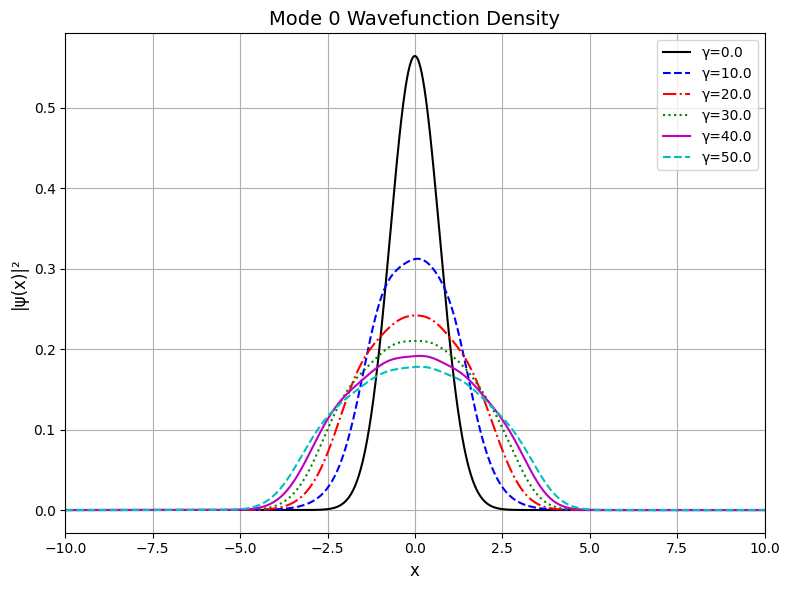

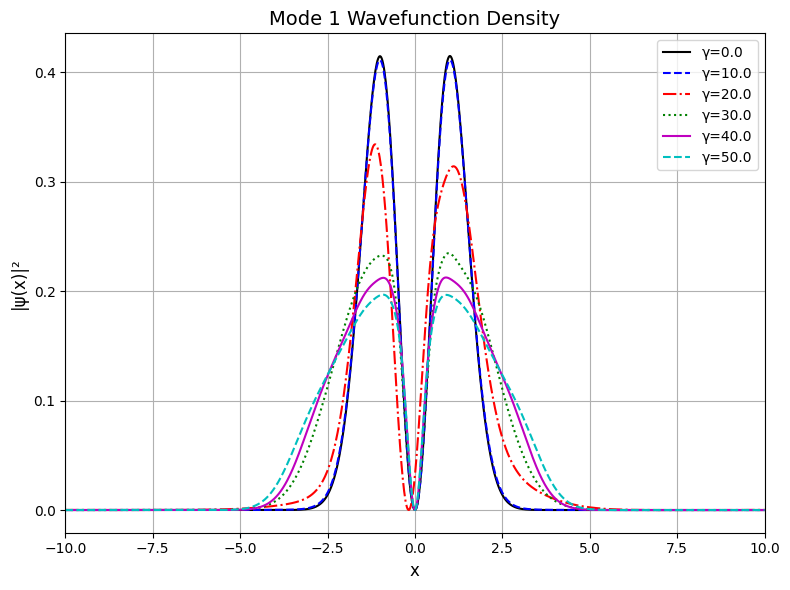

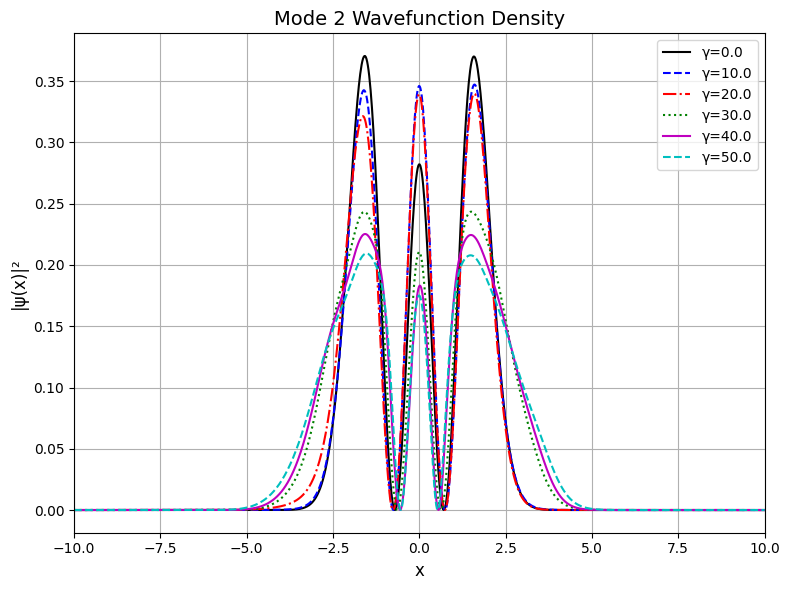

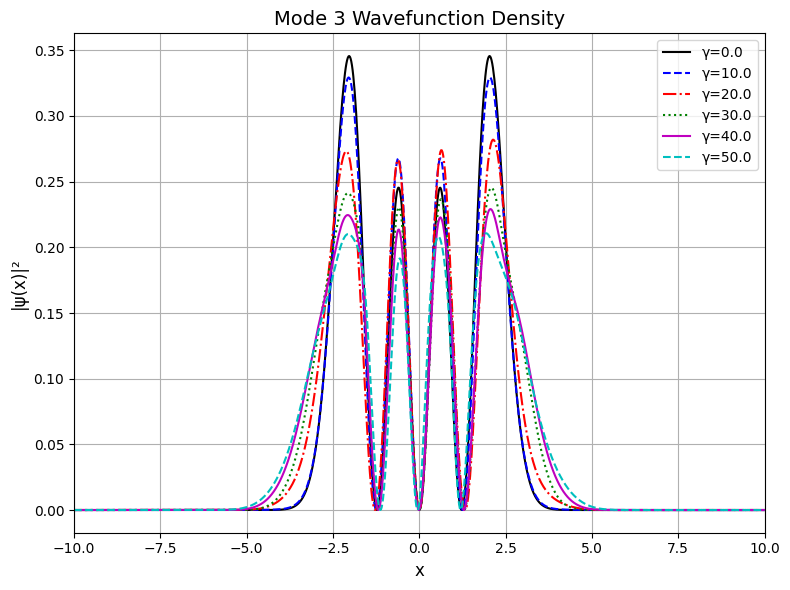

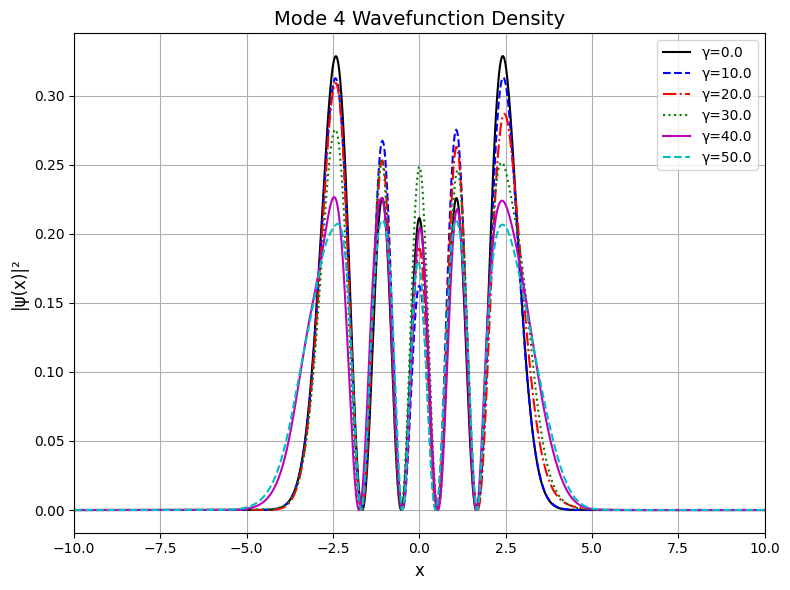

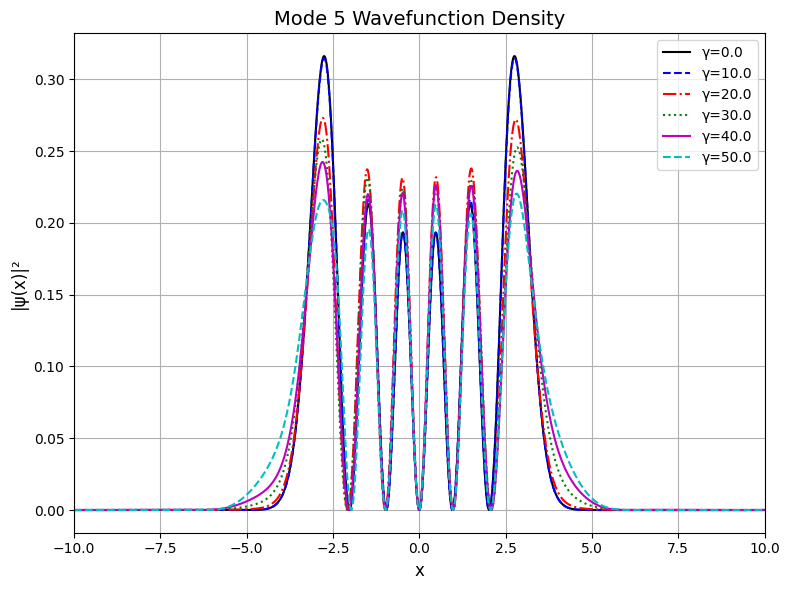

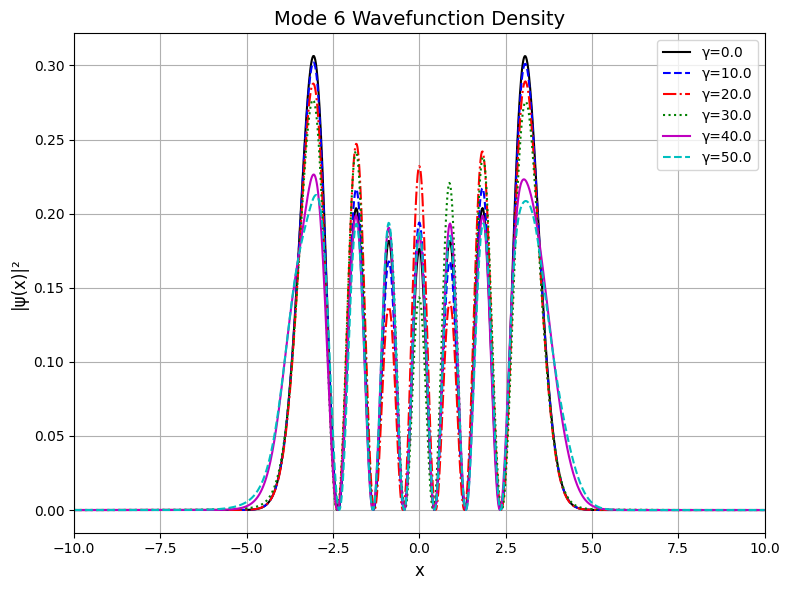

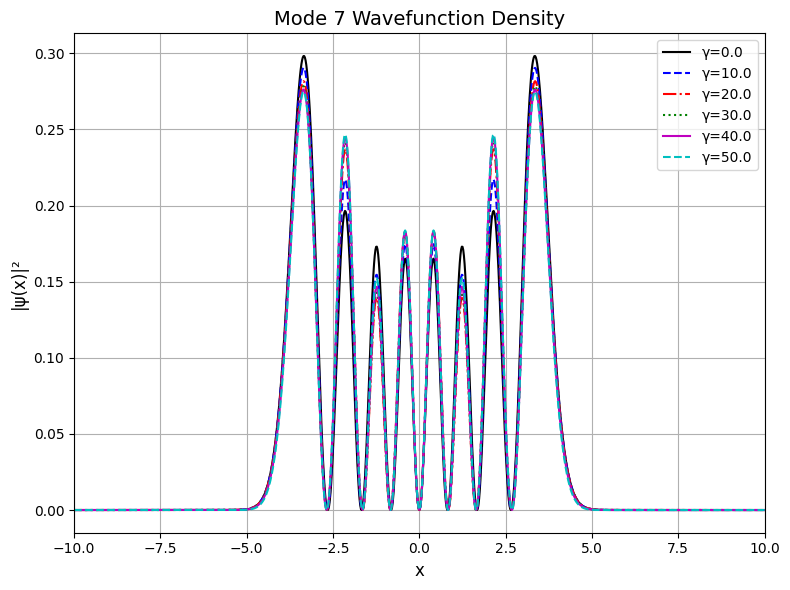

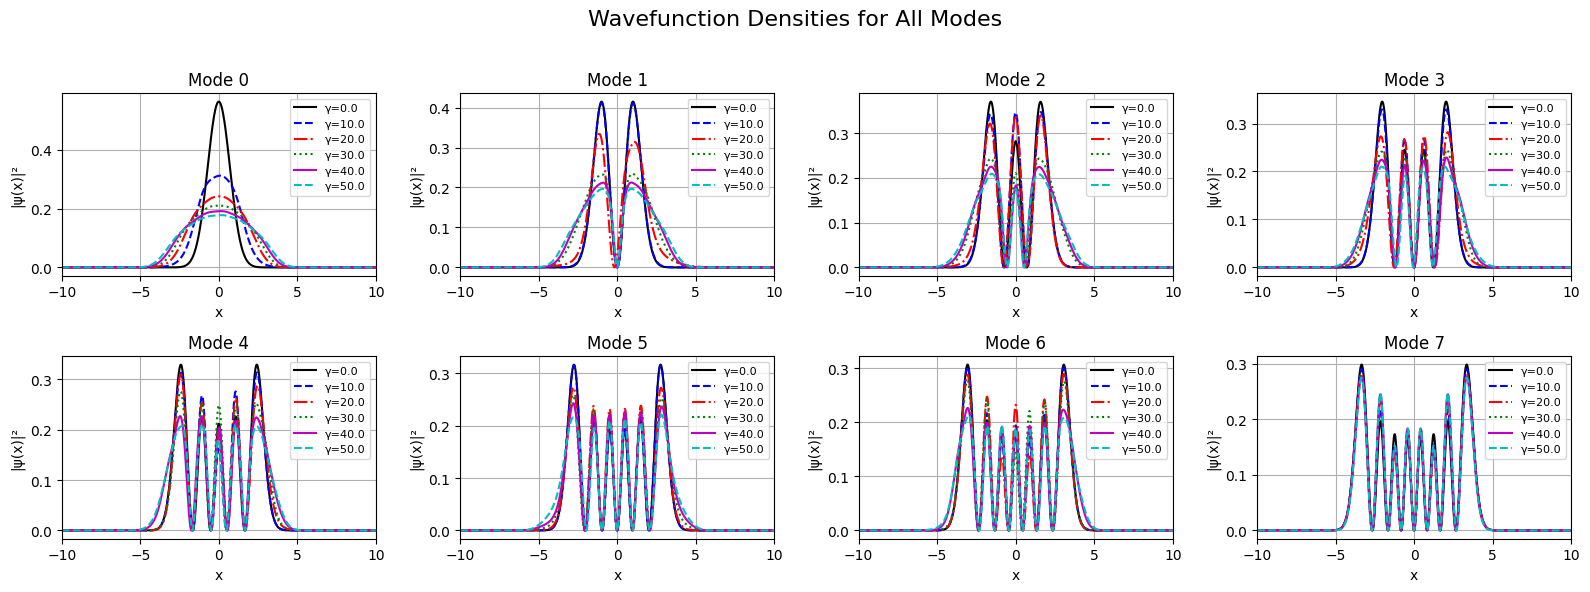

In [ ]:
# Plot wavefunction densities for individual modes
print("Generating individual mode plots...")
plot_wavefunction_densities(models_by_mode, X_test, gamma_values, modes, plots_dir)

# Plot μ vs γ for all modes

Generating chemical potential vs. gamma plot...


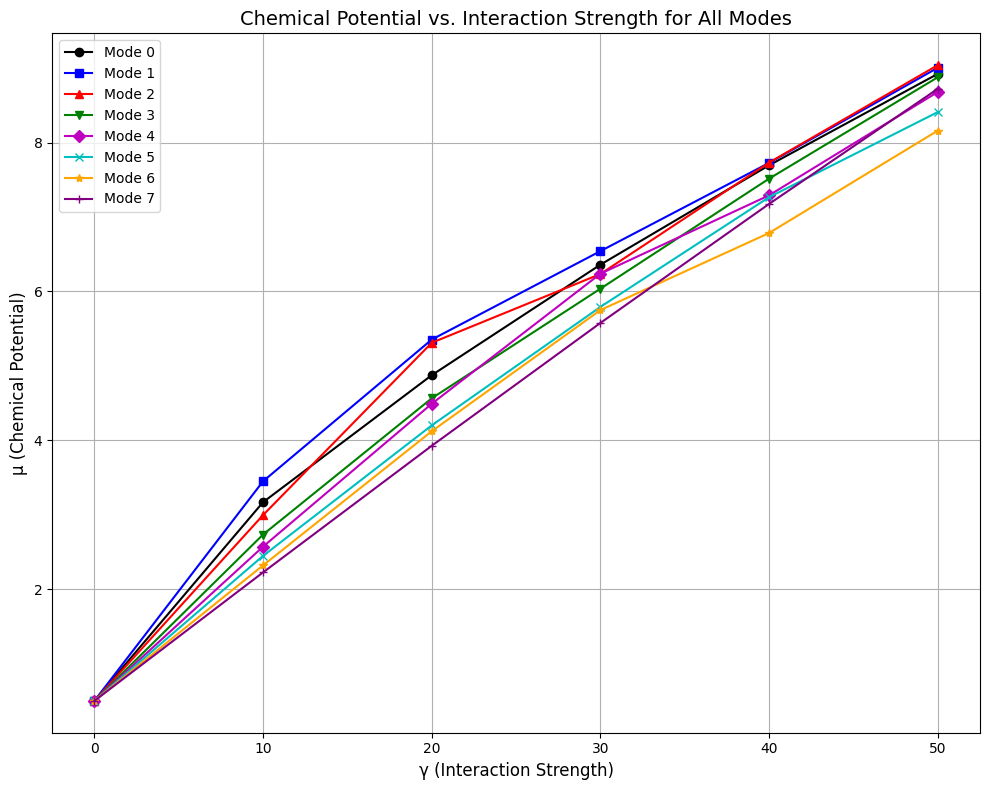

In [ ]:
print("Generating chemical potential vs. gamma plot...")
plot_mu_vs_gamma(mu_table, modes, plots_dir)

# Plot Individual Wavefunctions

In [ ]:
print("Generating wavefunction plots...")
plot_individual_wavefunctions(models_by_mode, X_test, gamma_values, modes, plots_dir)

# Compare with analytical solutions

In [ ]:
# Compare with analytical solutions for gamma=0
print("Comparing with analytical solutions...")
compare_with_analytical(models_by_mode, X_test, plots_dir)

# Plot energy components

In [ ]:
print("Analyzing energy components...")
plot_energy_components(models_by_mode, X_test, gamma_values, modes, plots_dir)

# Save Models and Data

In [ ]:
print("Saving models and data...")
save_results(models_by_mode, mu_table, os.path.join(results_dir, "models"))